# JCAP images & spectra hackathon
## Intro and motivation
This notebook gives an introduction to the dataset used in the research presented in Stein et al. Chem. Sci., 2019, 10, 47-55 https://doi.org/10.1039/C8SC03077D to generate embeddings from printed images and use them to predict full UV-Vis absorption spectra. The bigger picture for this scientific endeavour is the quest to find materials that are able to split water under irradiation of sunlight (solar water splitting) to generate renewable "solar" fuels. The scientists in the high-throughput experiementation group (HTE) at the Joint Center for Artificial Photosynthesis (JCAP - https://solarfuelshub.org/) therefore utilize ink-jet printing to deposit metal nitrate precursors onto transparent conducting oxides (TCO) that are annealed at high temperatures to form metal oxides. The images in this study (already encoded using a neural network in the dataset here) are optical microscopy images from a consumer grade photo scanner that is able to scan tens of thousands of materials images (ca. 4mm by 4mm) a minute. The information in these images is classic RGB CMOS data. Being able to tell from this very low-cost measurement how the full absorption spectra would qualitatively and quantitaively look like would not just enable the scientists to accelerate their discovery process but to also allow them to use the giant amount of materials images that have never been measured using UV-Vis spectroscopy.
The measurement workflow is shown below.


<img src="./jcap_workflow.png" alt="workflow" width="500">


## Technical introduction / reference

**THIS IS FOR REFERENCE, THERE IS NO NEED TO DOWNLOAD FROM THE EXTERNAL SITE** In their publication Stein et al. used a convolutional variational autoencoder to generate image embeddings, that for the purpose of this notebook, shall function as a surrogate representation of the images. What you have in this notebook is the embeddings for a subset of the over 100k images described by Stein et al. in https://doi.org/10.1038/s41597-019-0019-4 that can be downloaded at https://data.caltech.edu/records/1152 with code to wrangle with the dataset available at https://github.com/helgestein/materials-images-spectra. 
The embeddings for images are already generated for you as this process requires training of a larger deep neural network and takes about 30 min to complete. 

**For the bandgap prediction a word of precaution should be made:** We calculate the bandgap only for those spectra where reasonable values were found for both the predicted and regressed bandgaps. The used algorithm for bandgap extraction is not very stable and can predict bandgaps outside a physically meaningful range. Also, we know that most materials are multiphase thus exhibit more than one bandgap. The algorithm finds the most dominant one.

# Load packages and files

In [1]:
%matplotlib inline
import os
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

Download files to SageMaker instance from S3.

In [2]:
jcap_pickle = 'jcap_optical_encoding.pickle'
energy_npy = 'energy_ev.npy'

def hook(t):
    def inner(bytes_amount):
        t.update(bytes_amount)
    return inner
#session = boto3.session.Session(profile_name='hack2020')
#s3 = session.client('s3')
s3 = boto3.client('s3')
for filename in [jcap_pickle, energy_npy]:
    filesize = boto3.resource('s3').Object('hackathon2020-prod', 'data/' + filename).content_length
    with tqdm(total=filesize, unit='B', unit_scale=True, desc=jcap_pickle) as t:
        s3.download_file('hackathon2020-prod', 'data/' + filename, filename, Callback=hook(t))

jcap_optical_encoding.pickle: 100%|██████████| 154M/154M [00:01<00:00, 136MB/s]  
jcap_optical_encoding.pickle: 100%|██████████| 1.01k/1.01k [00:00<00:00, 16.3kB/s]


Load local files into arrays or Pandas dataframe.

In [3]:
energy_ev = np.load(energy_npy)
jcap_df = pd.read_pickle(jcap_pickle)
jcap_df.shape

The dataframe is indexed with an entry id associated with a unique composition. The bandgap, 100-dimensional encoding from variational autoencoder in the reference, the optical-UV spectrum, and the atomic fraction of each element are listed for each entry.

## Preprocess Data

In [6]:
# # add a composition column 
# compositions = []
# for index, row in jcap_df.iterrows():
#     composition = {elem:round(comp,3) for elem, comp in zip(row['Fe':'Rb'].index, row['Fe':'Rb']) if comp != 0}
#     compositions.append(composition)

# processed_jcap_df = jcap_df[['bandgap', 'vae', 'spectrum']].copy()
# processed_jcap_df['composition'] = compositions

## Agents

#### 1. first test four different agent and decide which two are better

In [18]:
import time
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, TimeSeriesSplit, learning_curve, cross_val_score
from sklearn.metrics import mean_absolute_error, explained_variance_score
from tpot import TPOTRegressor

In [8]:
X = np.array([list(x) for x in np.array(jcap_df['vae'])])
y = np.array(jcap_df['bandgap'])

In [19]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=20, n_jobs=-1)
nn = MLPRegressor(random_state=1)

In [26]:
def plot_learning_curve(estimator, X, y, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 10), color=None, label=None):
    t0 = time.time()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_absolute_error')
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = -np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = -np.std(test_scores, axis=1)
    plthandle, = plt.plot(train_sizes, test_scores_mean, 'o-', color=color,
             label=label,ms=15)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color=plthandle.get_color())
    print('Total time', time.time()-t0) 

Total time 1.5927329063415527
Total time 267.08924174308777
Total time 150.4772527217865


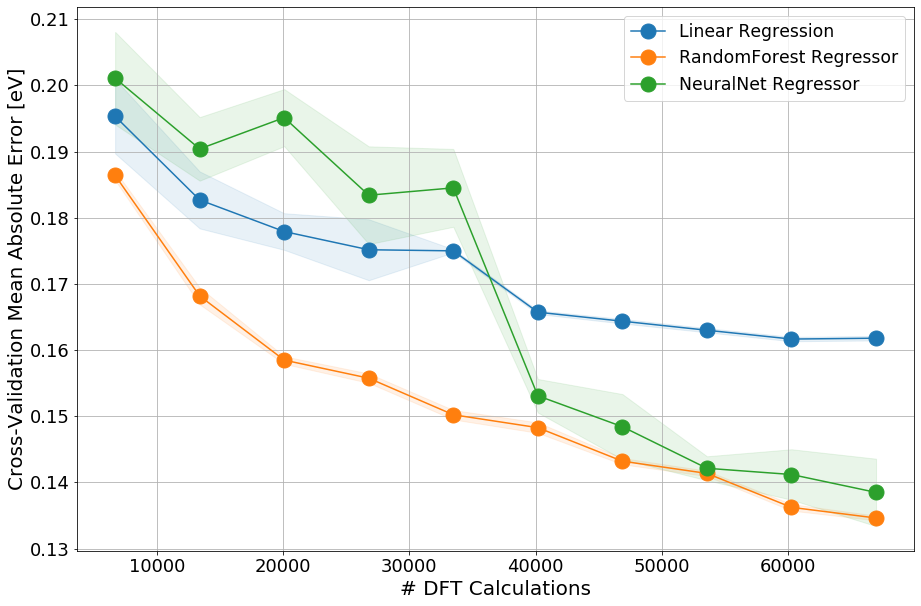

In [29]:
plt.figure(figsize=(15,10))
plt.grid()

plot_learning_curve(lr, X, y, cv=kf, n_jobs=4, label='Linear Regression')
plot_learning_curve(rf, X, y, cv=kf, n_jobs=4, label='RandomForest Regressor')
plot_learning_curve(nn, X, y, cv=kf, n_jobs=4, label='NeuralNet Regressor')

plt.xlabel('# Experiment',fontsize=20)
plt.ylabel('Cross-Validation Mean Absolute Error [eV]',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc='upper right', fontsize='xx-large')
plt.savefig('lr_rf_nn_learning_curves.pdf')
plt.show()

Observation from the learning curves:
* RandomForest and NeuralNet (aka. multi-layer perceptron in sklearn) Regressor performs better when the dataset is large (when we use all the data). 
* NN is worse than both LR and RF until the dataset is large. 
* RandomForest and NeuralNet both have more optimizable hyperparameters that might improve the prediction accuracy. 
* NN has the most uncertainty throughout. 
* Not pictured: knn_regressor and svm_regressor are also tried but their training took a lot longer. 

NN and RF are chosen for the hyperparamater optimization. 

#### 2. Finalize two regressors and optimize their paramaters

In [50]:
from scipy.stats import norm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [34]:
def report(results, n_top=2):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [37]:
# Split the overall data into train, test. We will use shuffle split
X = np.array([list(x) for x in np.array(jcap_df['vae'])])
y = np.array(jcap_df['bandgap'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest 
#-------------------------------------------------------------
rf = RandomForestRegressor(n_jobs=-1)
rf_params = {'n_estimators':[5, 10, 20], 'random_state':[None, 1], 'min_samples_split':[2, 10, 20]}
rf_clf = GridSearchCV(rf, rf_params)
start = time.time()
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

In [40]:
print("Random Forest SearchCV took %.2f seconds" % ((time.time() - start)))
report(rf_clf.cv_results_)
best_rf = rf_clf.best_estimator_

Random Forest SearchCV took 1465.17 seconds
Model with rank: 1
Mean validation score: 0.610 (std: 0.008)
Parameters: {'min_samples_split': 10, 'n_estimators': 20, 'random_state': 1}

Model with rank: 2
Mean validation score: 0.610 (std: 0.008)
Parameters: {'min_samples_split': 10, 'n_estimators': 20, 'random_state': None}



In [42]:
nn_params = {'hidden_layer_sizes': [(100, ), (200, ), (300, )], 'solver':['sgd', 'adam']}
nn = MLPRegressor()
nn_clf = GridSearchCV(nn, nn_params)
start = time.time()
nn_clf.fit(X_train, y_train)
y_pred = nn_clf.predict(X_test)
print("Random Forest SearchCV took %.2f seconds" % ((time.time() - start)))
report(nn_clf.cv_results_)
best_nn = nn_clf.best_estimator_

Random Forest SearchCV took 842.26 seconds
Model with rank: 1
Mean validation score: 0.608 (std: 0.017)
Parameters: {'hidden_layer_sizes': (300,), 'solver': 'adam'}

Model with rank: 2
Mean validation score: 0.606 (std: 0.017)
Parameters: {'hidden_layer_sizes': (200,), 'solver': 'adam'}



In [46]:
import pickle
best_estimators = {'random_forest': best_rf, 
                   'neural net': best_nn}
pickle.dump(best_estimators, open('best_rf_nn_estimators.pkl', 'wb'))

#### 3. Design Agents

In [85]:
from camd.agent.base import HypothesisAgent

In [72]:
# (shuffle) and split the df into seed and candidate df, half and half
seed_df, candidate_df = train_test_split(jcap_df, test_size=0.5)
sorted_jcap_df = jcap_df.sort_values('bandgap')
candidate_df = candidate_df[['vae']].copy()

3.1 RandomForest Agent

In [100]:
class RFHardnessAgent(HypothesisAgent):
    def get_hypotheses(self, candidate_data, seed_data):
        # Fit on known data
        x_known = np.array([list(x) for x in np.array(seed_data['vae'])])
        y_known = np.array(seed_data['bandgap'])
        regressor = best_rf
        regressor.fit(x_known, y_known)
        
        # Predict unknown data
        x_unknown =np.array([list(x) for x in np.array(candidate_data['vae'])])
        y_predicted = regressor.predict(x_unknown)
        candidate_data['bandgap_pred'] = y_predicted
        candidate_data = candidate_data.sort_values(by=['bandgap_pred'])
        top_candidates = pd.concat([candidate_data.head(5), candidate_data[6:15].sample(n=3)])
        return top_candidates
    
### Test agent here
rfagent = RFHardnessAgent()
rf_hypotheses = rfagent.get_hypotheses(candidate_df, seed_df)

,vae,bandgap_pred
comp_id,,
92923,"[0.08136622, 0.17715588, -0.13503048, 0.092828...",0.980596
93086,"[0.01545996, 0.2530085, -0.035263464, 0.127947...",0.981252
92957,"[-0.10697932, 0.08667364, -0.024271503, -0.045...",1.007134
93020,"[0.010051196, 0.06132173, 0.20147388, 0.070619...",1.054981
93065,"[-0.018286826, 0.32820874, -0.14746442, 0.1143...",1.063357
92932,"[-0.009920241, 0.04956758, 0.086294375, 0.1071...",1.131625
93125,"[-0.14645672, -0.13028136, -0.20514247, -0.149...",1.141794
93016,"[-0.00025531463, 0.02687803, 0.14591722, -0.02...",1.102557


3.2 NN (or MLP) Agent

In [101]:
class NNHardnessAgent(HypothesisAgent):
    def get_hypotheses(self, candidate_data, seed_data):
        # Fit on known data
        x_known = np.array([list(x) for x in np.array(seed_data['vae'])])
        y_known = np.array(seed_data['bandgap'])
        regressor = best_nn
        regressor.fit(x_known, y_known)
        
        # Predict unknown data
        x_unknown =np.array([list(x) for x in np.array(candidate_data['vae'])])
        y_predicted = regressor.predict(x_unknown)
        candidate_data['bandgap_pred'] = y_predicted
        candidate_data = candidate_data.sort_values(by=['bandgap_pred'])
        top_candidates = pd.concat([candidate_data.head(5), candidate_data[6:15].sample(n=3)])
        return top_candidates
    
### Test agent here
nn_agent = NNHardnessAgent()
nn_hypotheses = nn_agent.get_hypotheses(candidate_df, seed_df)

## Experiment

In [102]:
from camd.experiment.base import ATFSampler

In [109]:
# Random Forest 
rf_atf_experiment = ATFSampler(dataframe=sorted_jcap_df)
rf_atf_experiment.submit(rf_hypotheses)
rf_results = rf_atf_experiment.get_results()

In [110]:
# Neural Net
nn_atf_experiment = ATFSampler(dataframe=sorted_jcap_df)
nn_atf_experiment.submit(nn_hypotheses)
nn_results = nn_atf_experiment.get_results()

## Analyzers

In [92]:
from camd.analysis import AnalyzerBase

In [111]:
class BandGapAnalyzer(AnalyzerBase):
    def analyze(self, new_experimental_results, seed_data):
        new_seed = pd.concat(
            [seed_data, new_experimental_results],
        axis=0)
        # Create a summary
        average_new_badgap = new_experimental_results.bandgap.mean()
        average_dataset_new_badgap  = new_seed.bandgap.mean()
        new_result_ranks = new_seed.bandgap.rank(pct=True).loc[
            new_experimental_results.index
        ]
        summary = pd.DataFrame({
            "average_new_bandgap": [average_new_badgap],
            "average_dataset_bandgap": [average_dataset_new_badgap],
            "average_rank": [new_result_ranks.mean()]
        })
        return summary, new_seed

In [112]:
k_analyzer = BandGapAnalyzer()
rf_summary, new_seed = k_analyzer.analyze(rf_results, seed_df)
rf_summary

,average_new_bandgap,average_dataset_bandgap,average_rank
0,1.133635,2.311527,0.007108


In [113]:
k_analyzer = BandGapAnalyzer()
nn_summary, new_seed = k_analyzer.analyze(nn_results, seed_df)
nn_summary

,average_new_bandgap,average_dataset_bandgap,average_rank
0,1.272095,2.311549,0.008893


## Campaign

In [114]:
import os
from monty.os import cd
from camd.campaigns.base import Campaign
# Set up folders
os.system('rm -rf test')
os.system('mkdir -p test')
# Reinitialize experiment to clear history
k_atf_experiment = ATFSampler(dataframe=sorted_jcap_df)
with cd('test'):
    campaign = Campaign(
        candidate_data=candidate_df, 
        seed_data=seed_df,
        agent=rfagent,
        experiment=rf_atf_experiment,
        analyzer=k_analyzer
    )
    campaign.auto_loop(initialize=True)

Campaign initialization state: Agent RFHardnessAgent hypothesizing
Campaign 0 state: Running experiments
Iteration: 0
Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent RFHardnessAgent hypothesizing
Campaign 0 state: Running experiments
  Waiting for next round ...
Iteration: 1
Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent RFHardnessAgent hypothesizing
Campaign 1 state: Running experiments
  Waiting for next round ...
Iteration: 2
Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent RFHardnessAgent hypothesizing
Campaign 2 state: Running experiments
  Waiting for next round ...
Iteration: 3
Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent RFHardnessAgent hypothesizing
Campaign 3 state: Running experiments
  Waiting for next round ...
Iteration: 4
Campaign 4 state: Getting new results
Campaign 4 s

In [116]:
# _, result_history = rf_atf_experiment.agg_history
# candidate_df.style.apply(
#     lambda x: ['background: darkorange' 
#                if (x.name in result_history.index)
#                else '' for i in x], axis=1)